In [359]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    'x1': load_data('../stats/fpm_5_2D_x1.json'),
    'x4': load_data('../stats/fpm_5_2D_x2.json'),
    'x9': load_data('../stats/fpm_5_2D_x3.json'),
    'x16': load_data('../stats/fpm_5_2D_x4.json'),
    'x25': load_data('../stats/fpm_5_2D_x5.json'),
    'x36': load_data('../stats/fpm_5_2D_x6.json'),
}

In [360]:
shape = [3, 2]
figsize = (12, 6)

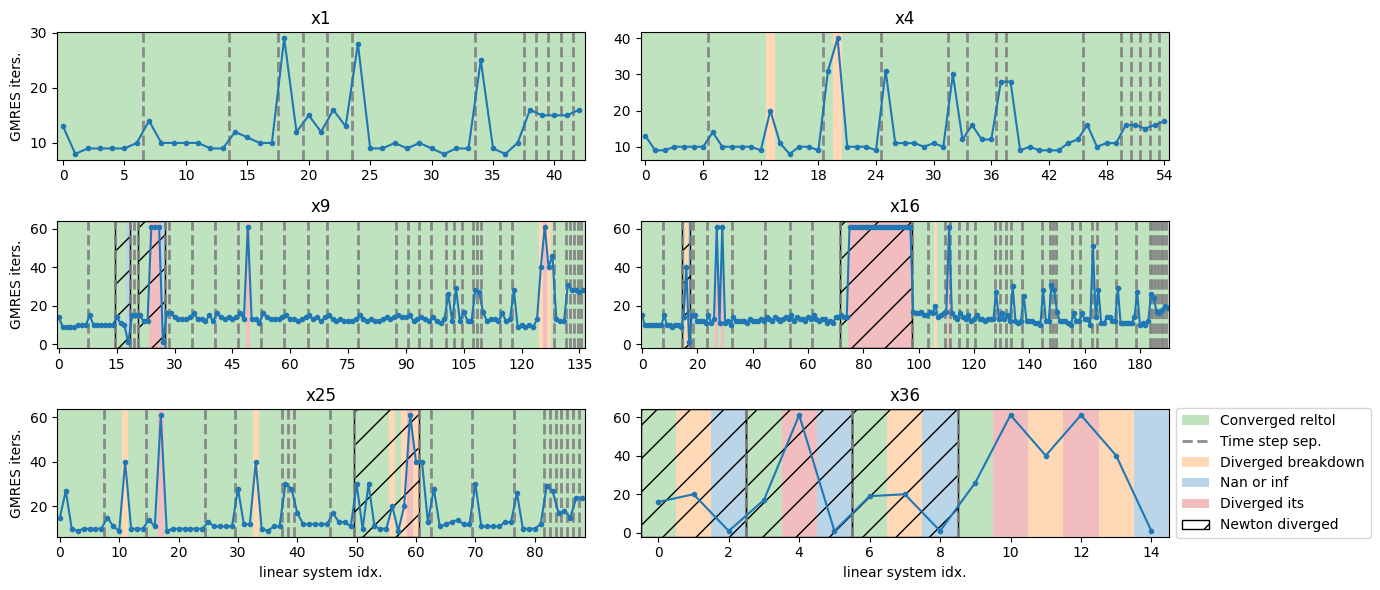

In [361]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

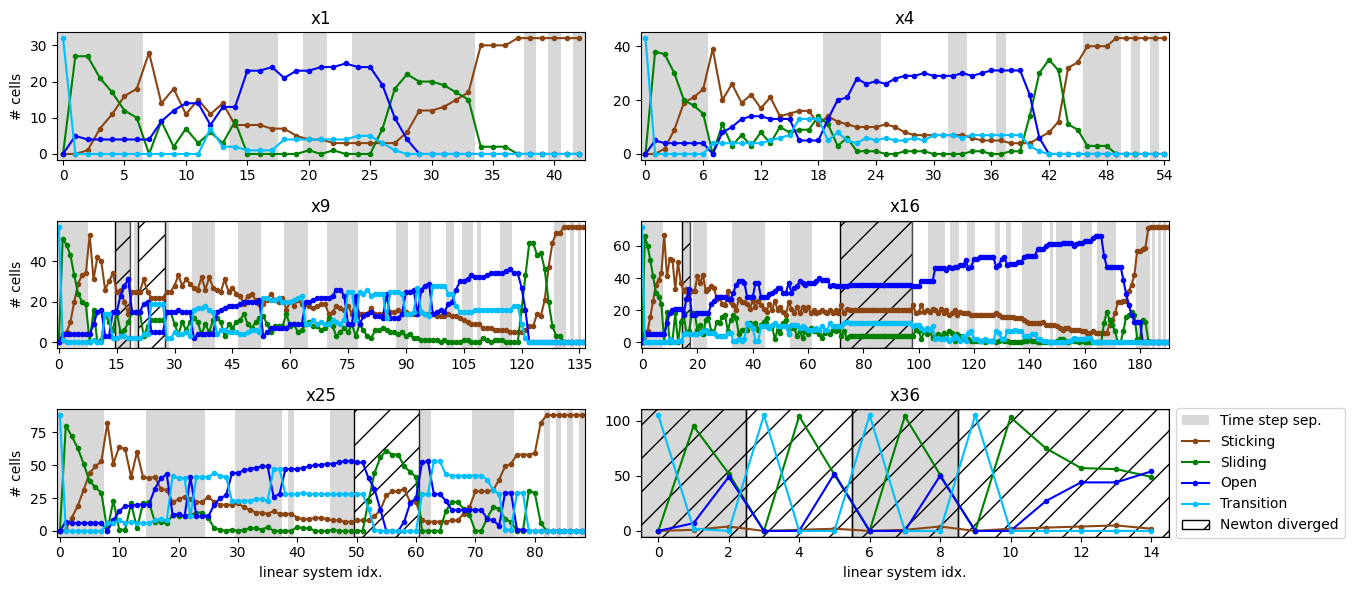

In [362]:
plot_grid(data, plot_sticking_sliding_open_transition, shape=shape, figsize=figsize, ylabel='# cells')

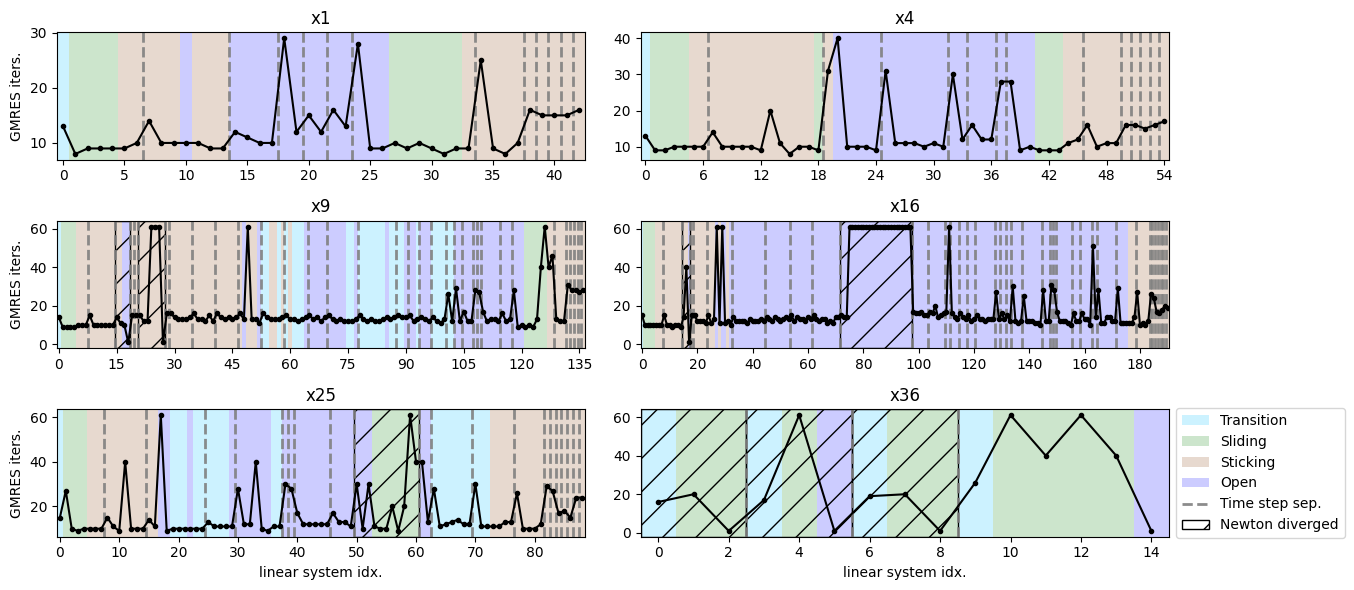

In [363]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.', color='black')
    # plt.ylim(top=15)

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

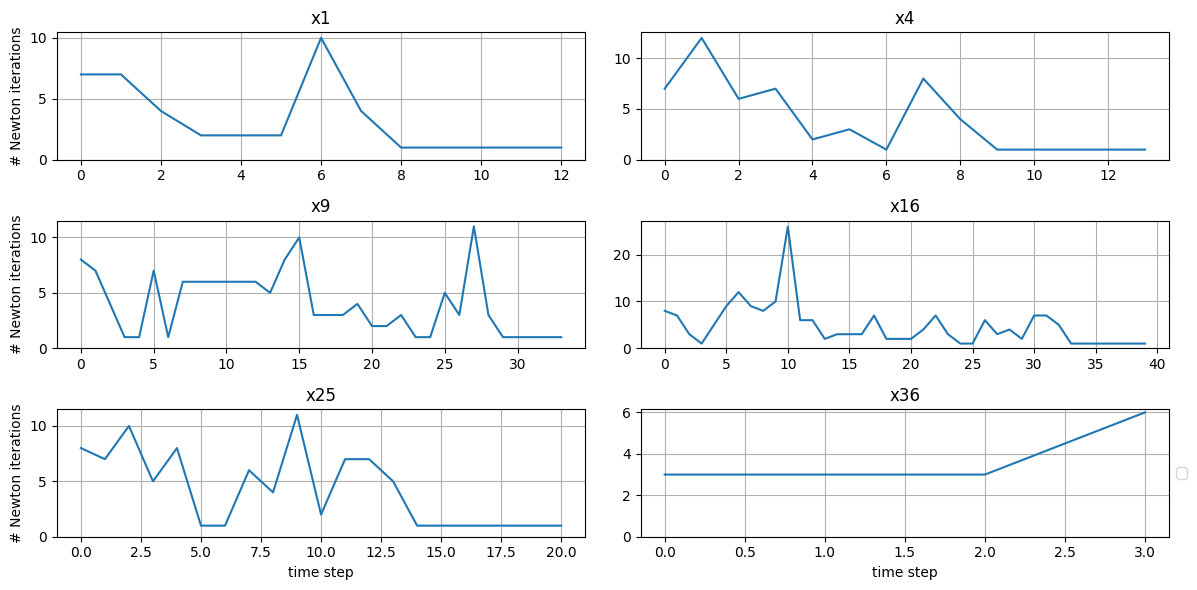

In [364]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# Newton iterations', xlabel='time step')

# Testing bad matrix

In [365]:
assert False

AssertionError: 

In [ ]:
from fpm_5_2D import make_model

model = make_model(cell_size_multiplier=2)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()



num sticking: 0
num sliding: 0
num open: 0
num transition: 43


In [ ]:
mat_idx = 13
entry = data["x4"]
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

40


In [ ]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)  # 1

model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

21
4
17
1


Solve  took: 0.29
True residual permuted: 1.0677173193864613
True residual: 1.0677173193864617
PETSc Converged Reason: -5
lambda min: 203.69225785177574


{'mat_Q': BlockMatrixStorage of shape (2565, 2565) with 88677 elements with 6x6 active groups}

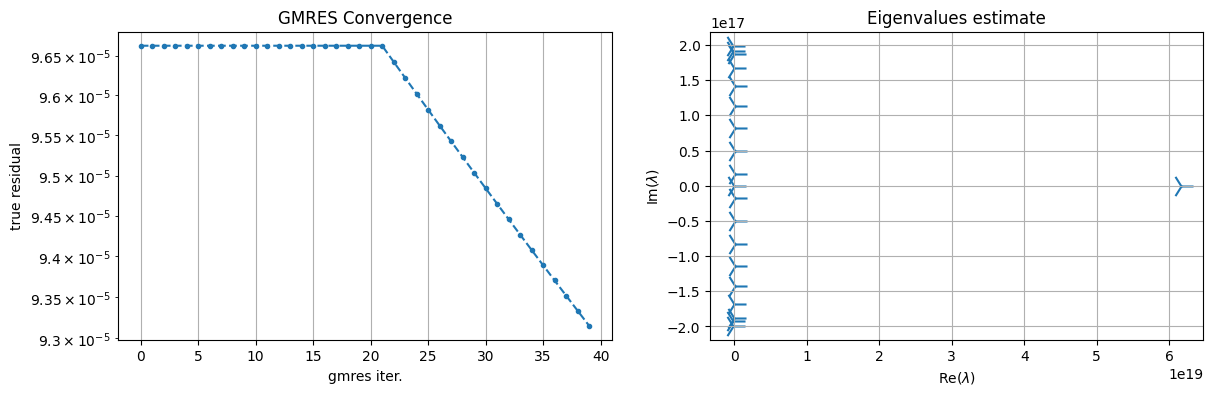

In [ ]:
sol = None
schema = model._prepare_solver()
solve_petsc_new(
    model.bmat,
    schema,
    rhs_global=rhs,
    # Qleft=model.Qleft,
    Qright=model.Qright,
    pc_side="right",
    tol=1e-10,
)

Solve  took: 0.03
True residual permuted: 8.914183077380642e-11
True residual: 2.533356987521188e-07
PETSc Converged Reason: 2


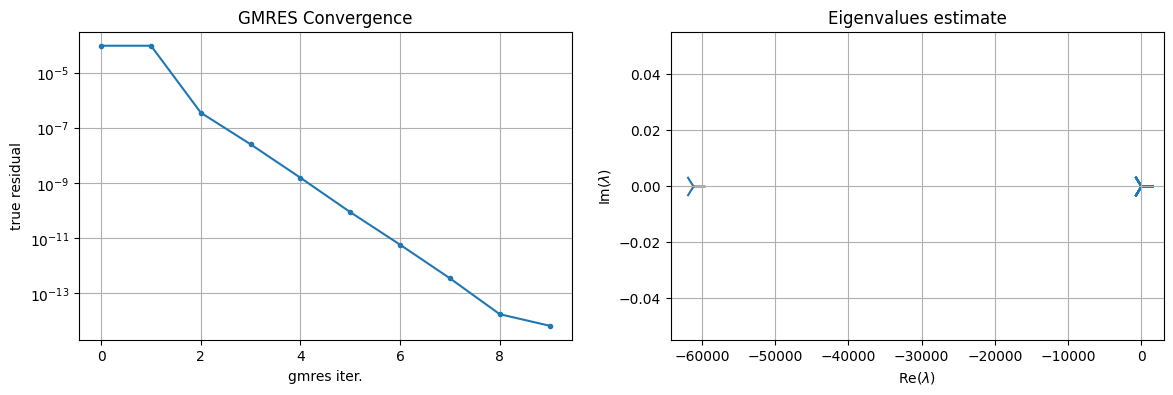

In [ ]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import *

schema = SolveSchema(
    groups=[4, ],
    # solve=lambda bmat: inv(mat=bmat[[4, 5]].mat),
    # only_complement=True,
    complement=SolveSchema(
        groups=[1,5],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1,5]].mat, dim=model.nd),
    ),
)

res = solve_petsc_new(
    model.bmat,
    schema,
    # Qleft=model.Qleft,
    Qright=model.Qright,
    rhs_global=rhs,
    pc_side="right",
    tol=1e-10,
    logx_eigs=False,
)

In [ ]:
J = model.bmat.copy()
J.mat = model.bmat.mat @ model.Qright.mat

In [ ]:

J55 = J[[5]].mat - J[5, 4].mat @ inv_block_diag(mat=J[4,4].mat, nd=model.nd) @ J[4,5].mat
J55_inv = inv_block_diag(mat=J55, nd=model.nd, lump=False)

cond(J55_inv @ J55)

1.581962704996715